### **1. Importing libraries and data**

In [295]:
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline

train = pd.read_csv("/Users/ruchika/Downloads/all/train.csv")
test = pd.read_csv("/Users/ruchika/Downloads/all/test.csv")

train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


***
### **2. Visualising the data**

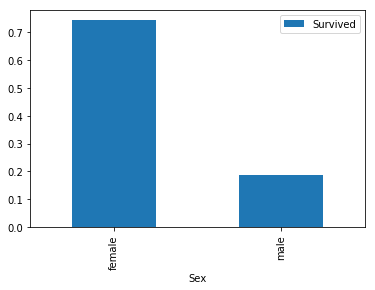

In [296]:
#Survival by sex
sex_plt = train.pivot_table(index = "Sex",values = "Survived")
sex_plt.plot.bar()

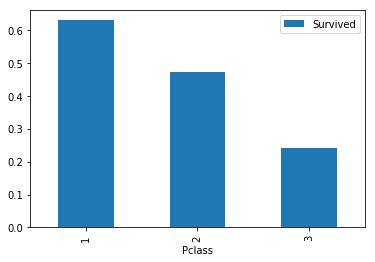

In [297]:
#Survival by class
Pclass_plt = train.pivot_table(index = "Pclass",values = "Survived")
Pclass_plt.plot.bar()

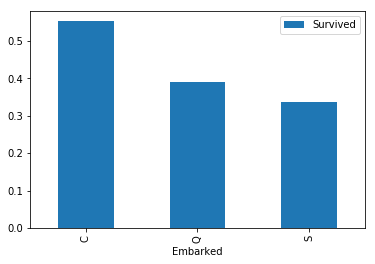

In [298]:
#Survival by port
Port_plt = train.pivot_table(index = "Embarked",values = "Survived")
Port_plt.plot.bar()

In [299]:
# Separate out the Titles
def separate_titles(df):
    df["Title"] = df["Name"].str.partition('.')[0].str.partition(', ')[2]
    df["Title"] = df["Title"].replace(['Miss','Mlle'],'Ms')
    df["Title"] = df["Title"].replace(['Don','Rev','Dr','Mme','Major','Sir','Col','Capt'],'Mr')
    df["Title"] = df["Title"].replace('Jonkheer','Master')
    df["Title"] = df["Title"].replace(['the Countess','Lady'],'Mrs')
    return df

train = separate_titles(train)
test = separate_titles(test)

In [300]:
title_age = train.pivot_table(index = "Title",values = "Age", aggfunc=np.mean)
title_age["Age"]

Title
Master     5.477568
Mr        32.989234
Mrs       35.981818
Ms        21.845638
Name: Age, dtype: float64

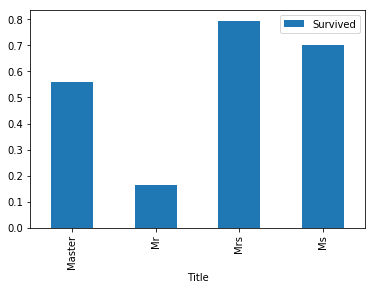

In [301]:
#Survival by Title
Title_plt = train.pivot_table(index = "Title",values = "Survived")
Title_plt.plot.bar()

In [302]:
# Process Age into categories
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_label"] = pd.cut(df["Age"],cut_points,labels = label_names)
    df["Age_label"] = df["Age_label"].fillna("Adult")

    return df

cut_points = [0,5,12,18,35,60,100]
label_names = ["Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)


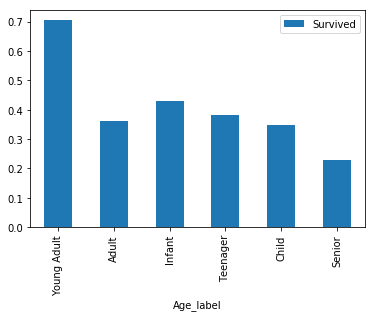

In [303]:
#Survival by age
Age_plt = train.pivot_table(index = "Age_label",values = "Survived")
Age_plt.plot.bar()

***
### **3. Pre processing the data**

In [325]:
# Converting into dummy columns
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_label","Title","Embarked"]:
    train = create_dummies(train,column)
    test = create_dummies(test,column)
        

***
### **4. Modelling the data**

In [319]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# columns to do prediction on
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age_label_Infant', 'Age_label_Child', 'Age_label_Teenager', 'Age_label_Young Adult', 'Age_label_Adult', 'Age_label_Senior', 'Title_Master', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [320]:
holdout = test # from now on we will refer to the 'kaggle' test data as the holdout data

# splitting the train data into train and test
from sklearn.model_selection import train_test_split

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.20,random_state=0)

In [321]:
lr.fit(train_X,train_y) # fitting the model to the train
predict_y = lr.predict(test_X) # predicting survival on test

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predict_y) # calculating accuracy

print(accuracy)

0.8212290502793296


In [322]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, all_X, all_y, cv=10) # calculating accuracy on cross validation
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.7752809  0.78888889 0.79775281 0.79775281 0.80898876 0.80898876
 0.82222222 0.82954545 0.83146067 0.88764045]
0.814852173419589


In [323]:
predict_holdout = lr.predict(holdout[columns]) # predicting survival on holdout

***
### **5. Submission**

In [324]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": predict_holdout}
submission = pd.DataFrame(submission_df)
submission.to_csv("/Users/ruchika/Downloads/all/submission.csv",index=False)